# FD-Schemes for European call

In [292]:
import math
import random
import numpy as np
from scipy.stats import norm
from tqdm import tqdm as _tqdm
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import seaborn as sns
sns.set(color_codes=True)
import scipy.stats as si
def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

plt.style.use('seaborn-darkgrid')
def black(S=100,K=110, r=0.04, sigma=0.3, T=1,option = 'call'):
    
    t1=T
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * t1) / (sigma * np.sqrt(t1))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * t1) / (sigma * np.sqrt(t1))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * t1) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * t1) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    return result
def hedge_parameter_bs(St, K, T, sigma, r, t=0):
    return norm.cdf((math.log(St/K) + (r + sigma ** 2 * 0.5) * (T - t)) / (sigma * math.sqrt(T - t)))

In [309]:
def FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04, M1=-5, M2=7, N_X=1000, N_T=1000, scheme='FTCS'):
    assert scheme in ['FTCS', 'CN'], 'Not a valid scheme type'
    # Initialization
    X0 = math.log(S0)
    
    grid = np.zeros((N_X+2, N_T+1))
    x_values = np.linspace(M1, M2, N_X+2)
    
    delta_x = x_values[2] - x_values[1]
    delta_tau = T / float(N_T)
    
    x_index = np.arange(1, N_X+1)
    tau_index = np.arange(1, N_T+1)
    
    # Setup boundaries on first column and last row
    grid[:, 0] = np.maximum(np.exp(x_values) - K, 0)
    grid[-1, 1:] = (np.exp(M2) - K) * np.exp(-r * tau_index * delta_tau)
    
    # Define coefficients to use in both schemes
    a = (2 * r - v**2) * delta_tau / (4 * delta_x)
    b = v**2 * delta_tau / (2 * delta_x**2)
    c = r * delta_tau + v**2 * delta_tau / (delta_x**2)
    
    # Compute coefficients and construct matrices A and B
    if scheme is 'FTCS':
        alpha =  - a + b
        beta = 1 - c
        gamma = a + b
        
        A = np.diag([alpha for i in range(N_X-1)], -1) + \
            np.diag([beta for i in range(N_X)]) + \
            np.diag([gamma for i in range(N_X-1)], 1)
        
        B = np.identity(N_X)
        B_inv = B
    else:
        alpha = (a - b) / 2
        beta = c / 2
        gamma = (- a - b) / 2
        
        A = np.diag([-alpha for i in range(N_X-1)], -1) + \
            np.diag([1-beta for i in range(N_X)]) + \
            np.diag([-gamma for i in range(N_X-1)], 1)
        
        B = np.diag([alpha for i in range(N_X-1)], -1) + \
            np.diag([1+beta for i in range(N_X)]) + \
            np.diag([gamma for i in range(N_X-1)], 1)
        B_inv = np.linalg.inv(B)
    
    # Traverse the grid
    for t in tau_index:
        # Get V^n from grid
        V_prev = grid[1:-1, t-1] #t-1first column
        
        if scheme is 'FTCS':
            # k_1 is 0
            k_new = np.zeros(N_X)
            
            # Construct k_2
            k_prev = np.zeros(N_X)
            k_prev[0] = 0
            k_prev[-1] = gamma * grid[-1, t-1] #k_prev is boundary condition
        else:
            # Construct k_1
            k_new = np.zeros(N_X)
            k_new[0] = 0
            k_new[-1] = gamma * grid[-1, t]
            
            # Construct k_2
            k_prev = np.zeros(N_X)
            k_prev[0] = 0
            k_prev[-1] = -gamma * grid[-1, t-1]
        
        # Compute V^{n+1}
        grid[1:-1, t] = B_inv.dot(A.dot(V_prev) + k_prev - k_new)
    
    # Interpolate value of option by looking at the last column of the grid
    opt_valuelist = [np.interp(math.log(100), x_values, grid[:, -1]),np.interp(math.log(110), x_values, grid[:, -1]),np.interp(math.log(120), x_values, grid[:, -1])]
    
    return opt_valuelist, grid, np.exp(x_values), delta_x, delta_tau

In [312]:
option_FT=np.array(FD_Schemes()[0])

In [384]:
FD_Schemes(scheme='CN')[0]

[9.626943853973781, 15.129887164181767, 21.791851044029734]

In [314]:
option_CN=np.array(FD_Schemes(scheme='CN')[0])

In [380]:
FD_Schemes()[4]

0.001

In [382]:
black(120)

21.788808338829327

# Compare results with BS

BS=9.62535 S_0=100

In [293]:
black(100)

9.625357828843697

In [306]:
option_FT

9.62831891223729

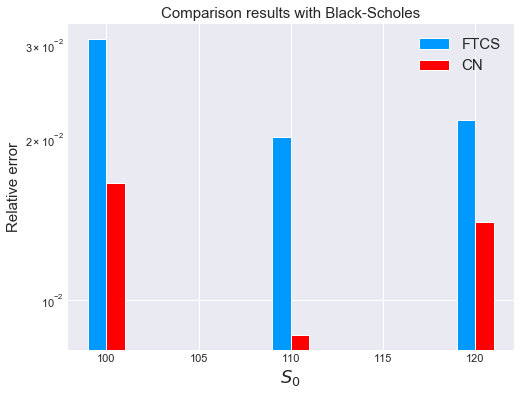

In [374]:
plt.figure(figsize=(8,6))
plt.bar(np.array([100,110,120])-0.5,[(option_FT[0]/9.62535-1)*100,(option_FT[1]/15.12859-1)*100,(option_FT[2]/21.78880-1)*100],width=1,color='#0099ff',label='FTCS')
plt.bar(np.array([100,110,120])+0.5,[(option_CN[0]/9.62535-1)*100,(option_CN[1]/15.12859-1)*100,(option_CN[2]/21.78880-1)*100],width=1,color='red',label='CN')
plt.ylabel('Relative error',size=15)
plt.xlabel('$S_0$',size=18)
plt.yscale('log')
plt.legend(fontsize=15)
plt.title('Comparison results with Black-Scholes',size=15)
plt.savefig('Compare_BS_F_CN.jpg',dpi=200,bbox_inches='tight')




In [376]:
def plot_3d_grid(S0, scheme,M1=-5, M2=7, N_X=1000, N_T=1000, restrict=True, savefig=False):
    print(f'Scheme {scheme}')
    f_N_X=N_X
    f_N_T=N_T
    _, grid, _, _, _ = FD_Schemes(S0=S0,
                                          M1=M1, M2=M2, N_X=N_X, N_T=N_T, scheme=scheme)
    
    fig = plt.figure(figsize=(10, 8))
    ax = Axes3D(fig)
    if restrict:
        x_range = np.linspace(M1, M2, f_N_X+2)
        idx = np.where(x_range > 3.5)[0][0]
        grid = grid[idx:, :]
    else:
        idx = 0
    t, X = np.meshgrid(np.linspace(0, 1, N_T+1), np.linspace(M1, M2, N_X+2)[idx:])
    if scheme == 'FTCS':
        ax.plot_surface(X, t, grid, cmap='PuBu', linewidth=0, antialiased=True)
    else:
        ax.plot_surface(X, t, grid, cmap='BuPu', linewidth=0, antialiased=True)
    ax.view_init(10,100 )
    ax.set_xlabel('X',size=15)
    ax.set_ylabel('tau',size=15)
    ax.set_zlabel('option price',size=15)
    plt.title('3D plot of ' + scheme,size=15)
    if savefig:
        plt.savefig(f'3d_grid_{scheme}_restrict_{restrict}.png', dpi=200,bbox_inches='tight')
    plt.show()

Scheme CN


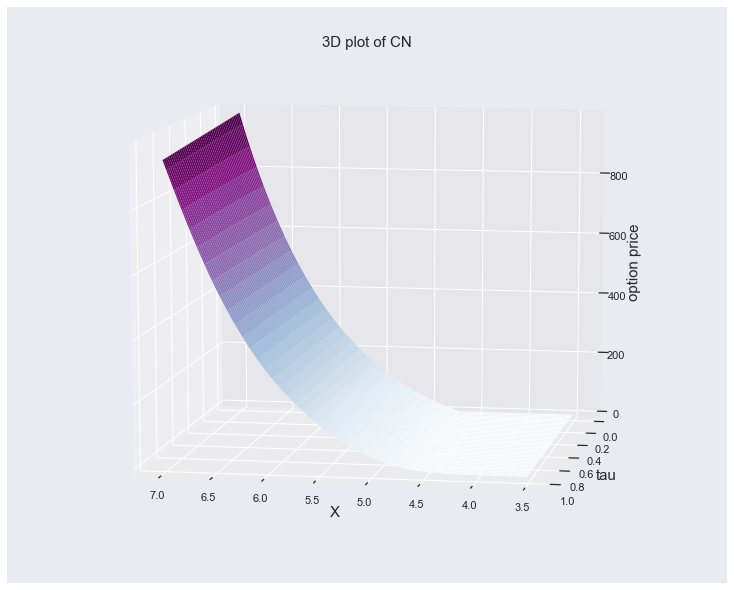

Scheme FTCS


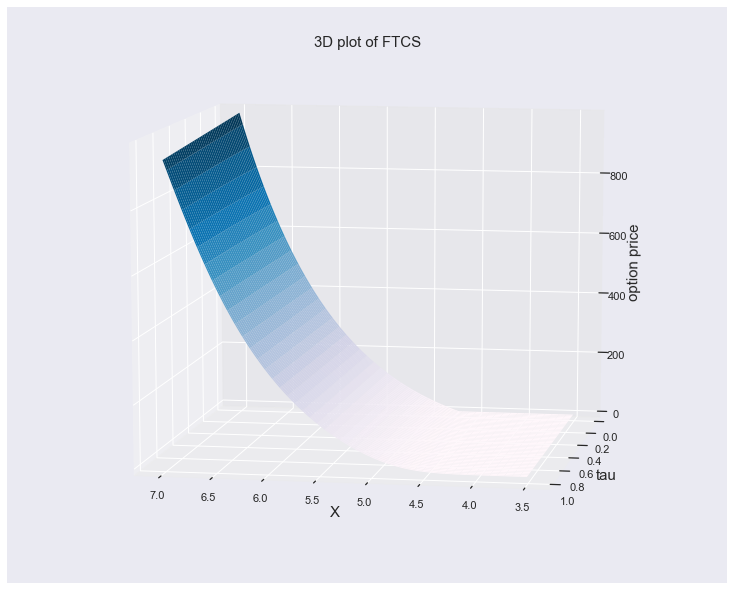

In [378]:
plot_3d_grid(100,'CN',savefig=True)
plot_3d_grid(100,'FTCS',savefig=True)

# convergence

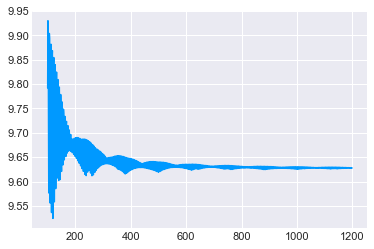

In [511]:
N_Xlist_3=np.arange(100,1200,1)
FTCS_N_X_convergence_5=np.array([FD_Schemes(N_X=i)[0][0] for i in N_Xlist_3])
plt.plot(N_Xlist_3,FTCS_N_X_convergence_5,label='FTCS',color='#0099ff')

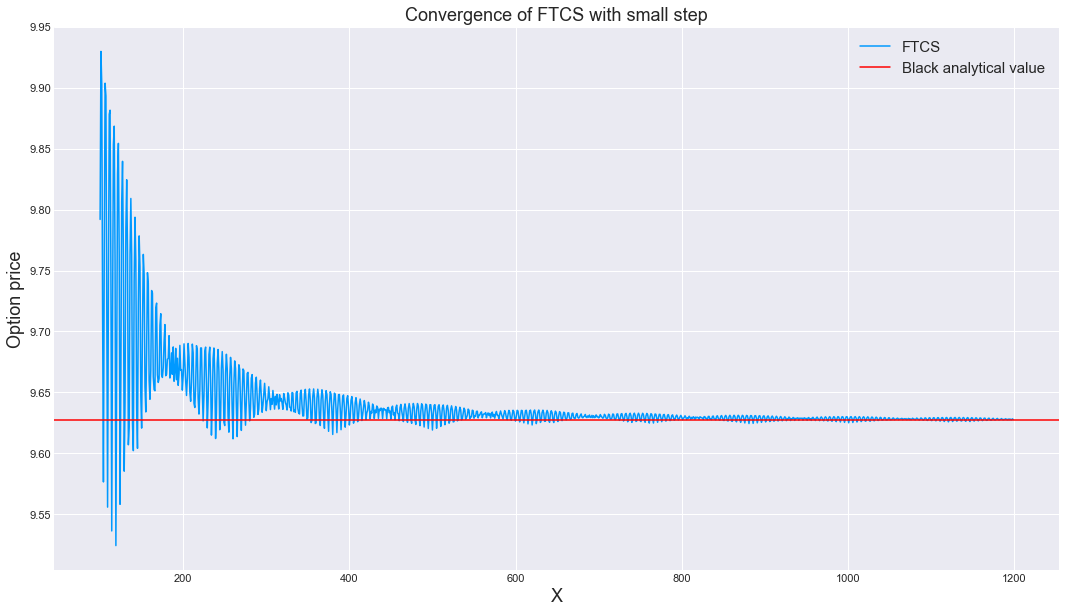

In [539]:
plt.figure(figsize=(18,10))
# plt.subplot(1,2,1)
plt.title('Convergence of FTCS with small step',size=18)
plt.plot(N_Xlist_3,FTCS_N_X_convergence_5,label='FTCS',color='#0099ff')
plt.axhline(9.626943853973781,color='red',label='Black analytical value')
plt.legend(fontsize=15)
plt.xlabel('X',size=18)
plt.ylabel('Option price',size=18)
plt.savefig('convergence_FTCS_small.jpg',dpi=200,bbox_inches='tight')
# plt.subplot(1,2,2)
# plt.plot(N_Xlist_3,abs(FTCS_N_X_convergence_5-9.626943853973781),label='FTCS',color='#0099ff')

In [503]:
N_Xlist_2=np.arange(100,1200,10)
FTCS_N_X_convergence_1=np.array([FD_Schemes(N_X=i)[0][0] for i in N_Xlist_2])
plt.plot(N_Xlist_2,FTCS_N_X_convergence_1,label='FTCS',color='#0099ff')

Text(0.5, 1.0, 'Absolute error of FTCS')

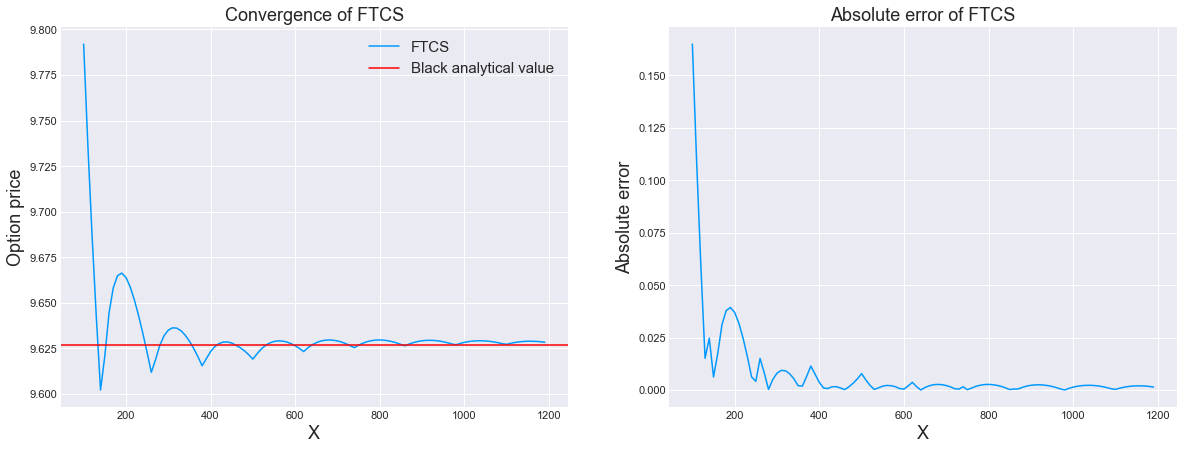

In [516]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(N_Xlist_2,FTCS_N_X_convergence_1,label='FTCS',color='#0099ff')
plt.title('Convergence of FTCS',size=18)
plt.axhline(9.626943853973781,color='red',label='Black analytical value')
plt.legend(fontsize=15)
plt.xlabel('X',size=18)
plt.ylabel('Option price',size=18)
plt.subplot(1,2,2)
plt.plot(N_Xlist_2,abs(FTCS_N_X_convergence_1-9.626943853973781),label='FTCS',color='#0099ff')
plt.xlabel('X',size=18)
plt.ylabel('Absolute error',size=18)
plt.title('Absolute error of FTCS',size=18)
# plt.yscale('log')
# plt.savefig('convergence_FTCS.jpg',dpi=200,bbox_inches='tight')

In [472]:
N_Xlist_1=np.arange(100,10000,500)
CN_N_X_convergence_1=np.array([FD_Schemes(N_X=i,scheme='CN')[0][0] for i in N_Xlist_1])

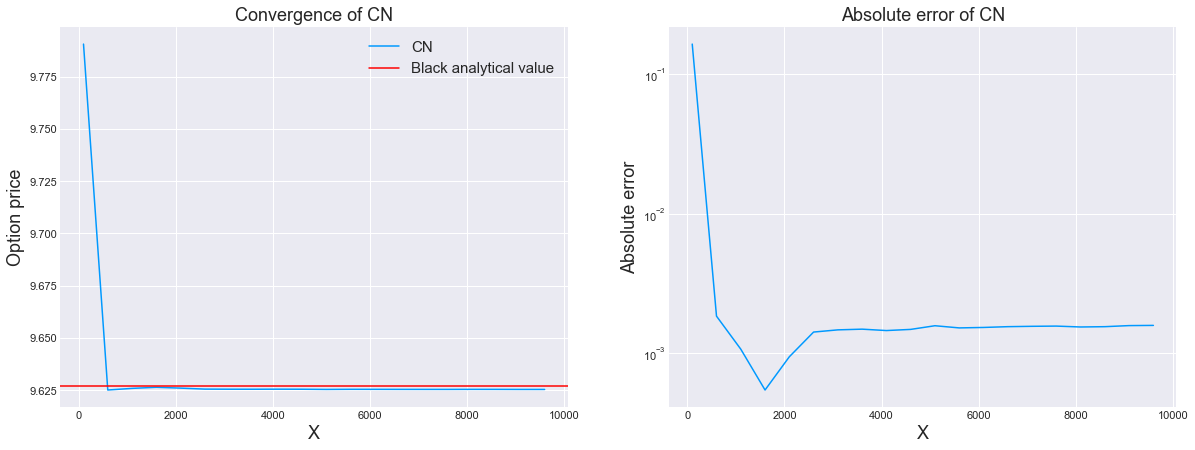

In [491]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(np.arange(100,10000,500),CN_N_X_convergence_1,label='CN',color='#0099ff')
plt.title('Convergence of CN',size=18)
plt.axhline(9.626943853973781,color='red',label='Black analytical value')
plt.legend(fontsize=15)
plt.xlabel('X',size=18)
plt.ylabel('Option price',size=18)
plt.subplot(1,2,2)
plt.plot(np.arange(100,10000,500),abs(CN_N_X_convergence_1-9.626943853973781),label='CN',color='#0099ff')
plt.xlabel('X',size=18)
plt.ylabel('Absolute error',size=18)
plt.title('Absolute error of CN',size=18)
plt.yscale('log')
plt.savefig('convergence.jpg',dpi=200,bbox_inches='tight')

# Optimal mesh point

In [235]:
N_Xlist=np.arange(100,1500,50)
N_Tlist=np.arange(100,2000,50)
FTCS_N_X=np.array([FD_Schemes(N_X=i)[0] for i in N_Xlist])
FTCS_N_T=np.array([FD_Schemes(N_T=i)[0] for i in N_Tlist])

In [521]:
N_Xlist=np.arange(100,1200,50)
FTCS_N_X=np.array([FD_Schemes(N_X=i)[0][0] for i in N_Xlist])

In [522]:
FTCS_N_X

array([9.79192095, 9.62071076, 9.6639335 , 9.622772  , 9.63500074,
       9.62901652, 9.62325114, 9.62794585, 9.61911614, 9.62881121,
       9.62647374, 9.62816623, 9.62909715, 9.62678637, 9.62963054,
       9.62717554, 9.62919786, 9.62866108, 9.62831891, 9.62909557,
       9.62724812, 9.6289372 ])

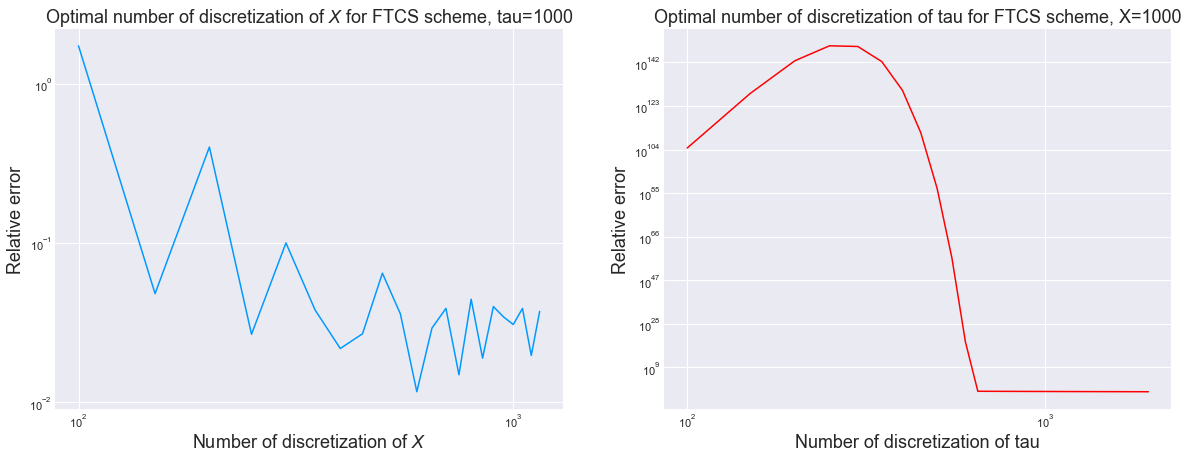

In [525]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title('Optimal number of discretization of $X$ for FTCS scheme, tau=1000',size=18)
plt.plot(np.arange(100,1200,50),abs((FTCS_N_X/9.62535-1)*100),color='#0099ff')
plt.ylabel('Relative error',size=18)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of discretization of $X$ ',size=18)
plt.ylabel('Relative error',size=18)
plt.subplot(1,2,2)
plt.plot(np.arange(100,2000,50),abs((FTCS_N_T/9.62535-1)*100),color='red')
plt.title('Optimal number of discretization of tau for FTCS scheme, X=1000',size=18)
plt.xlabel('Number of discretization of tau',size=18)
plt.ylabel('Relative error',size=18)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Optimal_number_FTCS.jpg',dpi=200,bbox_inches='tight')
plt.show()

In [246]:
N_Xlist=np.arange(100,6000,500)
CN_N_X=np.array([FD_Schemes(N_X=i,scheme='CN')[0] for i in N_Xlist])

In [223]:
N_Tlist=np.arange(100,10000,1000)
CN_N_T=np.array([FD_Schemes(N_T=i,scheme='CN')[0] for i in N_Tlist])

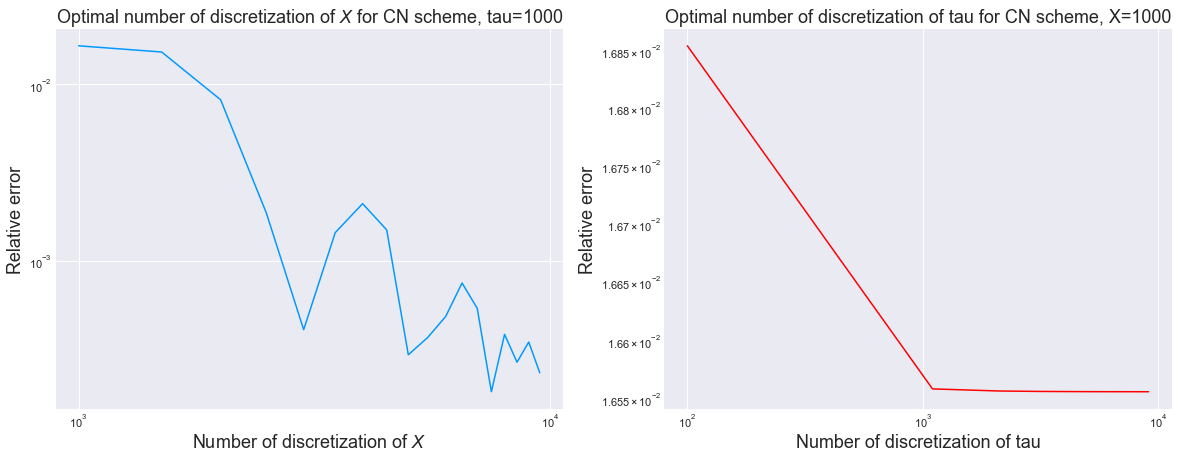

In [517]:

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title('Optimal number of discretization of $X$ for CN scheme, tau=1000',size=18)
plt.plot(np.arange(1000,10000,500),abs(CN_N_X_convergence/9.62535-1)*100,color='#0099ff')
plt.ylabel('Relative error',size=18)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of discretization of $X$ ',size=18)
plt.ylabel('Relative error',size=18)
plt.subplot(1,2,2)
plt.plot(np.arange(100,10000,1000),abs((CN_N_T/9.62535-1)*100),color='red')
plt.title('Optimal number of discretization of tau for CN scheme, X=1000',size=18)
plt.xlabel('Number of discretization of tau',size=18)
plt.ylabel('Relative error',size=18)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Optimal_number_CN.jpg',dpi=200,bbox_inches='tight')
plt.show()

# delta

In [468]:
def compute_and_plot_delta(S0=100, K=110, T=1, v=0.3, r=0.04, M1=-5, M2=7, N_X=1000, N_T=2000, scheme='CN',
                           restrict=True, S_min=10, S_max=200, savefig=False):
    # Get FD Scheme data
    _, grid, S0_val, _, _ = FD_Schemes(S0, K, T, v, r, M1, M2, N_X, N_T, scheme=scheme)
    
    x_values = np.linspace(M1, M2, N_X+2)
    V = grid[:, -1]
    
    # Compute deltas for FD Schemes, either restricted to interval or on full domain
    fd_delta = []
    bs_delta = []
    if not restrict:
        for i in np.arange(1, N_X+1):
            fd_delta.append((V[i+1] - V[i-1]) / (S0_val[i+1] - S0_val[i-1]))
            bs_delta.append(hedge_parameter_bs(S0_val[i], K, T, v, r))

        S0_val = S0_val[1:-1]
    else:
        S_values = np.arange(S_min-1, S_max+1, 1)
        for i in np.arange(1, len(S_values)-1):
            V_i = np.interp(np.log(S_values[i-1]), x_values, V)
            V_i_next = np.interp(np.log(S_values[i+1]), x_values, V)
            fd_delta.append((V_i_next - V_i) / (S_values[i+1] - S_values[i-1]))
            bs_delta.append(hedge_parameter_bs(S_values[i], K, T, v, r))
            if S_values[i] == 100 or S_values[i] ==110 or S_values[i]==120:
                print(S_values[i],(V_i_next - V_i) / (S_values[i+1] - S_values[i-1]))
                
        S0_val = S_values[1:-1]
    
    # Plot lines
    plt.figure(figsize=(8, 6))
    plt.plot(S0_val, fd_delta, label=scheme, alpha=0.8,color='red')
    plt.plot(S0_val, bs_delta,'--',label='Black-Scholes',color='#0099ff')
    plt.xlabel('$S_0$',size=18)
    plt.ylabel('Delta',size=18)
    plt.title('Estimate delta of '+scheme, size=18)
    plt.legend(fontsize=15)
    if savefig:
        plt.savefig(f'delta_N_X_{scheme}_restrict_{restrict}.png', dpi=200)
    plt.show()
    
    if restrict:
        fd_d = np.array(fd_delta)
        bs_d = np.array(bs_delta)
        print(f'Mean absolute error: {np.mean(np.abs(fd_d - bs_d)):.6f}')

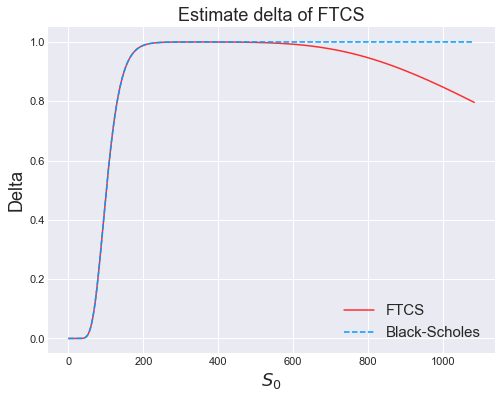

In [542]:
# compute_and_plot_delta(restrict=False)
compute_and_plot_delta(scheme='FTCS',restrict=False, savefig=True)

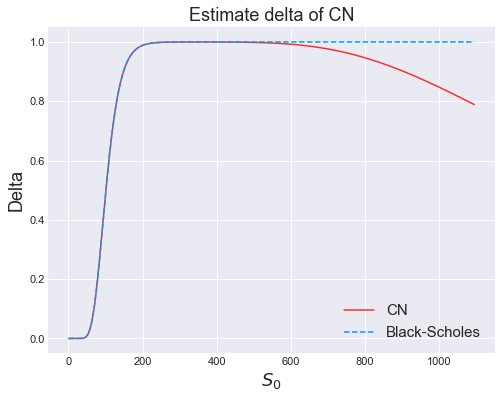

In [541]:
compute_and_plot_delta(scheme='CN', N_X=10000, N_T=2000,restrict=False, savefig=True)

100 0.48627576387534344
110 0.6115061297110174
120 0.7167611841870443


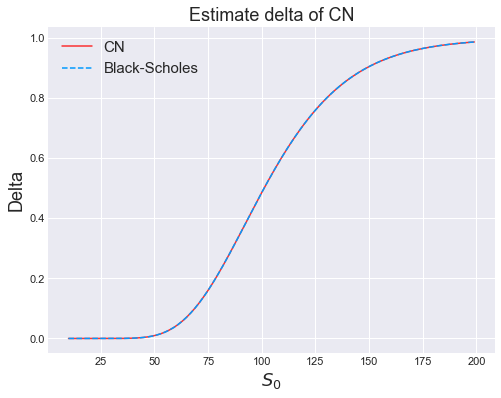

Mean absolute error: 0.000024


In [526]:
compute_and_plot_delta(scheme='CN', N_X=10000, N_T=2000)

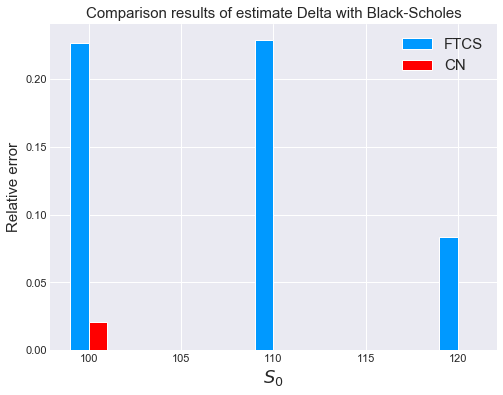

In [533]:
plt.figure(figsize=(8,6))
plt.bar(np.array([100,110,120])-0.5,[abs(0.4851/0.4862-1)*100,abs(0.6101/0.6115-1)*100,abs(0.7162/0.7168-1)*100],width=1,color='#0099ff',label='FTCS')
plt.bar(np.array([100,110,120])+0.5,[(0.4863/0.4862-1)*100,(0.6115/0.6115-1)*100,(0.7168/0.7168-1)*100],width=1,color='red',label='CN')
plt.ylabel('Relative error',size=15)
plt.xlabel('$S_0$',size=18)
# plt.yscale('log')
plt.legend(fontsize=15)
plt.title('Comparison results of estimate Delta with Black-Scholes',size=15)
plt.savefig('Compare_BS_F_delta.jpg',dpi=200,bbox_inches='tight')